# <span style="color:#FF8888;">TF-ISF Model using <span style="color: #1E90FF;"> Semantic</span> and <span style="color: #1E90FF;">Statistical</span> Features </span>

# 📥 Install Libraries

In [1]:
!pip install rouge

# 📚 Import Libraries

In [2]:
import os
import re
import json
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import glob
from nltk.util import ngrams
from rouge import Rouge

# ⚙️ Settings

In [3]:
representation_technique = "tf-isf"
n_grams = 1
similarity_measure = 1 # 1 means original cosine similarity and 2 means modifed cosine similarity
with_edge_thresholding = True
edge_weight_threshold = 0.02
# summary ratio now is adaptive
#summary_ratio = 0.3
ranking_method = 2 # 1 means degree centrality and 2 means textrank and 3 means pagerank
alpha = 0.54
max_iterations = 10
with_redundancy_reduction = False
redundancy_threshold = 0.5
print_file = "file151.json"

# 📂 Load JSON Data and Extract Sentences with Indexing

In [4]:
def load_json_file(file_path):
    """Load and parse a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_sentences(data, skip_title=True):
    """Extract all sentences from the nested JSON structure.
    
    Args:
        data: The JSON data containing paragraphs and sentences
        skip_title: If True, skip paragraph 0 (title)
    
    Returns:
        A list of tuples: (sentence_text, (paragraph_idx, sentence_idx))
    """
    sentences = []
    
    # Go through all paragraphs
    for para_idx in data:
        # Skip paragraph 0 (title) if skip_title is True
        if skip_title and para_idx == '0':
            continue
            
        # Go through all sentences in the paragraph
        for sent_idx in data[para_idx]:
            if isinstance(data[para_idx][sent_idx], str):
                # Store sentence text and its indices
                sentences.append((data[para_idx][sent_idx], (para_idx, sent_idx)))
    
    return sentences

# 🔡 Generate N-Grams from Text

In [5]:
def get_ngrams(text):
    """Extract n-grams from text.
    
    Args:
        text: Input text
        n_grams: (global variable) Size of n-grams (1 for unigrams, 2 for bigrams, etc.)
    
    Returns:
        List of n-grams
    """
    tokens = text.split()
    if n_grams == 1:
        return tokens
    else:
        return [' '.join(gram) for gram in ngrams(tokens, n_grams)]

# 📖 Compute TF-ISF

In [6]:
def compute_tf(sentence):
    """Compute term frequency for a sentence using n-grams."""
    # Extract n-grams from the sentence
    terms = get_ngrams(sentence)
    
    # Count the frequency of each term
    term_count = Counter(terms)
    
    # Calculate term frequency
    sentence_length = len(terms)
    
    # Avoid division by zero
    if sentence_length == 0:
        return {}
        
    tf = {term: count / sentence_length for term, count in term_count.items()}
    
    return tf

def compute_isf(sentence_texts):
    """Compute inverse sentence frequency for all terms in the corpus using n-grams."""
    # Count the number of sentences containing each term
    term_sentence_count = defaultdict(int)
    
    for sentence in sentence_texts:
        terms = set(get_ngrams(sentence))  # Use set to count each term only once per sentence
        for term in terms:
            term_sentence_count[term] += 1
    
    # Calculate ISF: log(total number of sentences / number of sentences containing the term)
    num_sentences = len(sentence_texts)
    isf = {term: math.log(num_sentences / count) for term, count in term_sentence_count.items()}
    
    return isf

def compute_tf_isf(sentence_data):
    """Compute TF-ISF vectors for each sentence using n-grams."""
    # Extract just the text from sentence data for ISF calculation
    sentence_texts = [s[0] for s in sentence_data]
    
    # Get ISF values for all terms
    isf = compute_isf(sentence_texts)
    
    # Compute TF for each sentence
    tf_per_sentence = [compute_tf(sentence) for sentence in sentence_texts]
    
    # Create a list of all unique terms
    all_terms = sorted(list(isf.keys()))
    term_to_idx = {term: idx for idx, term in enumerate(all_terms)}
    
    # Compute TF-ISF for each sentence
    tf_isf_vectors = []
    
    for tf in tf_per_sentence:
        # Initialize vector with zeros
        vector = np.zeros(len(all_terms))
        
        # Fill in TF-ISF values
        for term, tf_value in tf.items():
            if term in term_to_idx:  # Check if term exists (should always be true)
                idx = term_to_idx[term]
                vector[idx] = tf_value * isf[term]
        
        tf_isf_vectors.append(vector)
    
    return tf_isf_vectors, all_terms

def compute_title_tf_isf(title_text, sentence_data, n=1):
    """Compute TF-ISF vector for the title using the ISF values from the document's sentences."""
    # Extract all sentence texts (excluding the title) for ISF calculation
    sentence_texts = [s[0] for s in sentence_data]
    
    # Compute ISF values
    isf = compute_isf(sentence_texts)
    
    # Get all unique terms
    all_terms = sorted(list(isf.keys()))
    term_to_idx = {term: idx for idx, term in enumerate(all_terms)}
    
    # Compute TF for the title
    tf_title = compute_tf(title_text)
    
    # Initialize the title vector with zeros
    title_vector = np.zeros(len(all_terms))
    
    # Compute TF-ISF for the title
    for term, tf_value in tf_title.items():
        if term in term_to_idx:  # Ensure the term exists in ISF
            idx = term_to_idx[term]
            title_vector[idx] = tf_value * isf[term]
    
    return title_vector

# 📏 Compute Similarity

In [7]:
def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Avoid division by zero
    if norm_v1 == 0 or norm_v2 == 0:
        return 0
    
    return dot_product / (norm_v1 * norm_v2)

def modified_similarity(v1, v2, title, keyphrase_score_v2):
    #print(keyphrase_score_v2)
    return cosine_similarity(v1, v2) * (1 + keyphrase_score_v2 + cosine_similarity(v2, title))

# 📈 Build the Graph

In [8]:
def build_graph(sentence_data, title_text, keyphrase_scores):
    """
    Build a graph where nodes are sentences and edges represent modified similarity above a threshold.
    
    Args:
        sentence_data: List of tuples (sentence_text, (para_idx, sent_idx))
        title_text: The text of the document title
        keyphrase_scores: Dictionary of keyphrase scores by paragraph and sentence indices
        threshold: Minimum similarity threshold for creating an edge
        ngram_size: Size of n-grams to use for TF-ISF calculation
    
    Returns:
        Tuple of (graph, tf_isf_vectors, terms)
    """
    # Compute TF-ISF vectors
    tf_isf_vectors, terms = compute_tf_isf(sentence_data)
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes (sentences) with their indices
    for i, (sentence_text, (para_idx, sent_idx)) in enumerate(sentence_data):
        node_id = f"{para_idx}_{sent_idx}"
        
        # Get keyphrase score for this sentence (default to 0 if not found)
        keyphrase_score = 0
        statistical_score = 0
        if para_idx in keyphrase_scores and sent_idx in keyphrase_scores[para_idx]:
            keyphrase_score = keyphrase_scores[para_idx][sent_idx].get('keyphrase_score', 0)
            statistical_score = keyphrase_scores[para_idx][sent_idx].get('statistical_score', 0)
        
        G.add_node(
            node_id, 
            text=sentence_text, 
            para_idx=para_idx, 
            sent_idx=sent_idx, 
            vector_idx=i,
            keyphrase_score=keyphrase_score,
            statistical_score=statistical_score
        )
    
    title_vector = compute_title_tf_isf(title_text, sentence_data, n=1)
    
    # Calculate similarities for all pairs
    similarities = []
    sentence_pairs = []
    
    for i, (_, (para_i, sent_i)) in enumerate(sentence_data):
        node_i = f"{para_i}_{sent_i}"
        keyphrase_score_i = G.nodes[node_i]['keyphrase_score']
        
        for j, (_, (para_j, sent_j)) in enumerate(sentence_data[i+1:], i+1):
            node_j = f"{para_j}_{sent_j}"
            keyphrase_score_j = G.nodes[node_j]['keyphrase_score']
            
            # Use modified similarity instead of cosine similarity
            if (similarity_measure == 2):
                similarity = modified_similarity(
                    tf_isf_vectors[i], 
                    tf_isf_vectors[j], 
                    title_vector,
                    keyphrase_score_j
                )
            else:
                similarity = cosine_similarity(
                    tf_isf_vectors[i], 
                    tf_isf_vectors[j]
                )
            
            similarities.append(similarity)
            sentence_pairs.append((node_i, node_j))
    
    # Normalize similarities if there are any
    if similarities:
        min_sim = min(similarities)
        max_sim = max(similarities)
        
        # Avoid division by zero if all similarities are the same
        if max_sim > min_sim:
            normalized_similarities = [(sim - min_sim) / (max_sim - min_sim) for sim in similarities]
        else:
            normalized_similarities = [1.0 for _ in similarities]
        
        # Add edges based on normalized similarities
        for (node_i, node_j), norm_sim in zip(sentence_pairs, normalized_similarities):
            if with_edge_thresholding:
                if norm_sim > edge_weight_threshold:
                    G.add_edge(node_i, node_j, weight=norm_sim)
            else:
                G.add_edge(node_i, node_j, weight=norm_sim)
    
    return G, tf_isf_vectors, terms

# 👀 Visualize Graph

In [9]:
def visualize_graph(G, filename=print_file):
    """Visualize the graph and display in the console."""
    plt.figure(figsize=(12, 10))
    
    # Use spring layout for better visualization
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    
    # Get edge weights for line thickness and color
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Draw edges with varying thickness based on weight
    nx.draw_networkx_edges(G, pos, width=[w*3 for w in edge_weights], alpha=0.7)
    
    # Draw node labels
    node_labels = {node: f"{data['para_idx']}_{data['sent_idx']}" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    
    plt.title(f"Sentence Similarity Graph for {filename if filename else 'Sample'}")
    plt.axis('off')
        
    # Instead of saving, just display the plot
    plt.show()

# 🛠️ All Graph Construction Stage

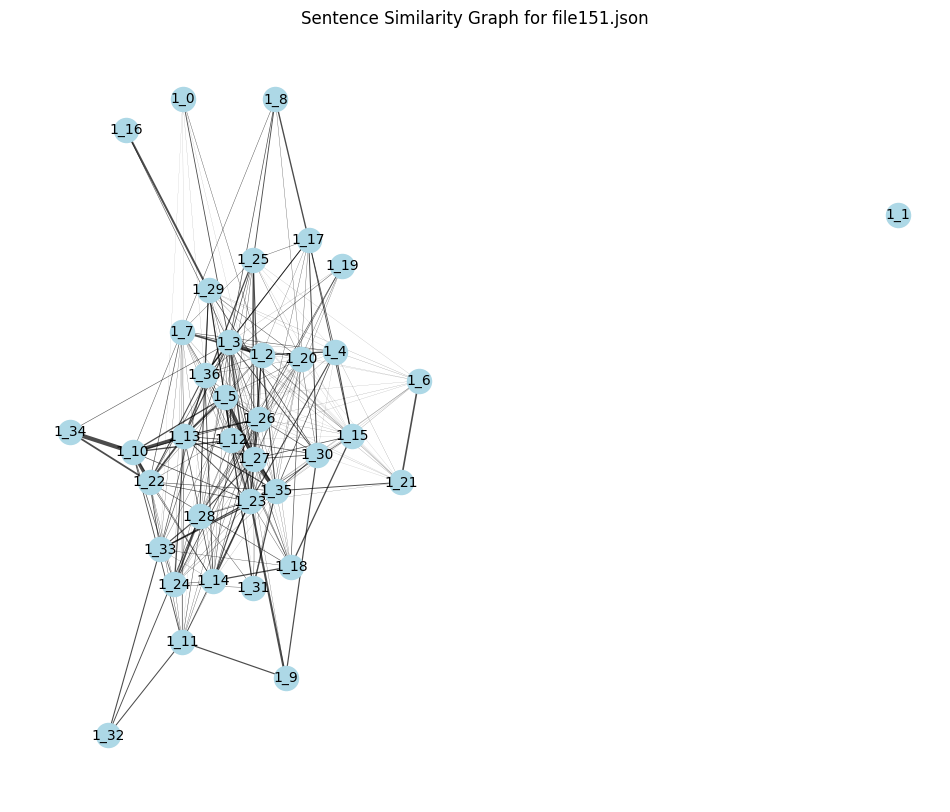

Successfully processed 153 files.


In [10]:
def process_file(file_path, scores_folder):
    """
    Process a single JSON file and return the results with enhanced similarity measures.
    
    Args:
        file_path: Path to the JSON file to process
        scores_folder: Path to the folder containing sentence scores
        threshold: Minimum similarity threshold for creating graph edges
        ngram_size: Size of n-grams to use for TF-ISF calculation
    
    Returns:
        Dictionary with processing results or None if processing failed
    """
    filename = os.path.basename(file_path)
    
    # Load document data
    data = load_json_file(file_path)
    
    # Load sentence scores
    scores_path = os.path.join(scores_folder, filename)
    keyphrase_scores = {}
    if os.path.exists(scores_path):
        keyphrase_scores = load_json_file(scores_path)
    
    # Extract the title
    title_text = ""
    if '0' in data and '0' in data['0']:
        title_text = data['0']['0']
    
    # Extract sentences (skipping title)
    sentence_data = extract_sentences(data, skip_title=True)
    
    if not sentence_data:
        print(f"No sentences found in {filename} after skipping title.")
        return None
    
    # Build graph with title and keyphrase scores
    graph, vectors, terms = build_graph(
        sentence_data, 
        title_text, 
        keyphrase_scores
    )

    if filename == print_file:
        visualize_graph(graph)
    
    return {
        'graph': graph,
        'vectors': vectors,
        'terms': terms,
        'sentences': sentence_data,
        'title': title_text,
        'keyphrase_scores': keyphrase_scores,
        'filename': filename
    }

def process_all_files(folder_path, scores_folder):
    """
    Process all JSON files in the given folder with keyphrase scores.
    
    Args:
        folder_path: Path to the folder containing document JSON files
        scores_folder: Path to the folder containing sentence scores
        threshold: Minimum similarity threshold for creating graph edges
        ngram_size: Size of n-grams to use for TF-ISF calculation
        
    Returns:
        Dictionary of processing results by filename
    """
    results = {}
    
    # Get all JSON files in the folder
    file_paths = glob.glob(os.path.join(folder_path, "*.json"))
    
    for file_path in file_paths:
        result = process_file(file_path, scores_folder)
        if result:
            results[result['filename']] = result
    
    return results


# Example usage
if __name__ == "__main__":
    documents_folder = "/kaggle/input/graduation-project/preprocessed_classical"
    scores_folder = "/kaggle/input/graduation-project/sentence_scores"
    
    results = process_all_files(documents_folder, scores_folder)
    
    print(f"Successfully processed {len(results)} files.")

# 🏆 Ranking

## Weighted Degree Centrality

In [11]:
def weighted_centrality(results):
    """
    Rank sentences in each file by weighted degree centrality.
    
    Args:
        results: Dictionary of results from process_all_files function
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order
    """
    rankings = {}
    scores_dir = "/kaggle/input/graduation-project/sentence_scores"
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        # Get just the filename without path and extension
        base_filename = os.path.basename(filename)
        base_filename = os.path.splitext(base_filename)[0]
        
        # Load the statistical scores for this file
        scores_path = os.path.join(scores_dir, f"{base_filename}.json")
        try:
            statistical_scores = load_json_file(scores_path)
        except FileNotFoundError:
            print(f"Warning: Statistical scores file not found for {filename}. Using empty scores.")
            statistical_scores = {}
        
        # Calculate weighted degree centrality for each node
        weighted_centrality = {}
        
        for node_id in graph.nodes():
            # Get node data
            node_data = graph.nodes[node_id]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            
            # Calculate the weighted centrality for this node
            centrality_score = 0
            
            # Iterate through all neighbors of the node
            for neighbor in graph.neighbors(node_id):
                # Get the similarity (edge weight) between the node and its neighbor
                similarity = graph[node_id][neighbor]['weight']
                
                # Get the statistical score for the neighbor
                neighbor_data = graph.nodes[neighbor]
                neighbor_para_idx = neighbor_data['para_idx']
                neighbor_sent_idx = neighbor_data['sent_idx']
                
                # Extract statistical score for the neighbor
                neighbor_stat_score = 0
                if neighbor_para_idx in statistical_scores and neighbor_sent_idx in statistical_scores[neighbor_para_idx]:
                    neighbor_stat_score = statistical_scores[neighbor_para_idx][neighbor_sent_idx].get('statistical_score', 0)
                
                # Add contribution of this neighbor to the centrality score
                centrality_score += similarity * neighbor_stat_score
            
            weighted_centrality[node_id] = centrality_score
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = []
        for node_id, score in weighted_centrality.items():
            # Get node data
            node_data = graph.nodes[node_id]
            text = node_data['text']
            
            sentence_scores.append((node_id, score, text))
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Store rankings
        rankings[filename] = sentence_scores
    
    return rankings

## Semantic TextRank

In [12]:

def semantic_TextRank(results, damping=0.85, max_iterations=100):
    rankings = {}
    scores_dir = "/kaggle/input/graduation-project/sentence_scores"
    
    for filename, result in results.items():
        #print(f"\nProcessing file: {print_file}")a
        graph = result['graph']
        sentences = result['sentences']
        
        base_filename = os.path.splitext(os.path.basename(filename))[0]
        scores_path = os.path.join(scores_dir, f"{base_filename}.json")
        
        try:
            statistical_scores = load_json_file(scores_path)
        except FileNotFoundError:
            print(f"Warning: Statistical scores file not found for {filename}. Using default scores.")
            statistical_scores = {}

        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue

        # Initialize TextRank scores: 1/N
        scores = np.ones(n) / n 
        
        # Precompute outgoing weights
        out_weights_sum = {}
        for node in nodes:
            out_sum = sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
            out_weights_sum[node] = max(out_sum, 1e-10)
        
        # Run TextRank iterations
        for _ in range(max_iterations):
            new_scores = np.ones(n) * (1 - damping)
            for i, node_i in enumerate(nodes):
                score_sum = 0
                for neighbor in graph.neighbors(node_i):
                    j = node_to_idx[neighbor]
                    weight = graph[node_i][neighbor]['weight']
                    norm_factor = np.sqrt(out_weights_sum[node_i] * out_weights_sum[neighbor])
                    score_sum += (weight * scores[j]) / norm_factor
                new_scores[i] += damping * score_sum
            if np.allclose(scores, new_scores, atol=1e-6):
                break
            scores = new_scores

        # Collect raw scores (TextRank and stat)
        raw_textrank_scores = scores
        raw_stat_scores = np.zeros(n)
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            stat_score = statistical_scores.get(para_idx, {}).get(sent_idx, {}).get('statistical_score', 0)
            raw_stat_scores[i] = stat_score 

        # Normalize both using same min and max
        combined_min = min(np.min(raw_textrank_scores), np.min(raw_stat_scores))
        combined_max = max(np.max(raw_textrank_scores), np.max(raw_stat_scores))
        combined_range = max(combined_max - combined_min, 1e-10)

        normalized_textrank = (raw_textrank_scores - combined_min) / combined_range
        normalized_stat = (raw_stat_scores - combined_min) / combined_range

        # Combine scores
        final_scores = alpha * normalized_textrank + (1 - alpha) * normalized_stat

        # Print scores
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            if filename == print_file:
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                print(f"    TextRank score:   {normalized_textrank[i]:.4f}")
                print(f"    Stat score:       {normalized_stat[i]:.4f}")
                print(f"    Final score:      {final_scores[i]:.4f}")

        # Store results
        sentence_scores = [
            (node, float(final_scores[i]), graph.nodes[node]['text']) for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

## PageRank

In [13]:
def rank_sentences_by_textrank(results):
    """
    Rank sentences in each file by TextRank algorithm.
    
    Args:
        results: Dictionary of results from process_all_files function
        max_iterations: (global variable) Maximum number of iterations for PageRank algorithm
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        # Calculate TextRank scores (PageRank) for each node with max iterations
        textrank_scores = nx.pagerank(graph, max_iter=max_iterations)
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = []
        for node_id, score in textrank_scores.items():
            # Get node data
            node_data = graph.nodes[node_id]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            text = node_data['text']
            
            sentence_scores.append((node_id, score, text))
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Store rankings
        rankings[filename] = sentence_scores
        
        # Optional: Calculate some statistics about the scores
        scores = [score for _, score, _ in sentence_scores]
    
    return rankings

## Mofified PageRank

In [14]:
def modified_pagerank(results):
    """
    Rank sentences in each file by TextRank algorithm with statistical scores as initial values.
    
    Args:
        results: Dictionary of results from process_all_files function.
    
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order.
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        # Build personalization dictionary directly from normalized statistical scores
        personalization = {
            node_id: graph.nodes[node_id].get('statistical_score', 0)
            for node_id in graph.nodes()
        }
        
        # Check if all scores are zero — fallback to uniform distribution
        if all(score == 0 for score in personalization.values()):
            personalization = None

        # Compute TextRank with personalization
        pagerank_scores = nx.pagerank(
            graph,
            max_iter=max_iterations,
            personalization=personalization
        )
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = [
            (node_id, score, graph.nodes[node_id]['text'])
            for node_id, score in pagerank_scores.items()
        ]
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores

    return rankings

In [15]:
if(ranking_method == 1):
    rankings = weighted_centrality(results)
elif(ranking_method == 2):
    rankings = semantic_TextRank(results)
elif(ranking_method == 3):
    print("pagerank")
    rankings = rank_sentences_by_textrank(results)
else:
    print("odified pagerank")
    rankings = modified_pagerank(results)

  Sentence [1][0]:
    TextRank score:   0.2085
    Stat score:       0.4763
    Final score:      0.3317
  Sentence [1][1]:
    TextRank score:   0.0631
    Stat score:       0.6404
    Final score:      0.3286
  Sentence [1][2]:
    TextRank score:   0.4866
    Stat score:       0.1591
    Final score:      0.3360
  Sentence [1][3]:
    TextRank score:   0.5899
    Stat score:       1.0000
    Final score:      0.7785
  Sentence [1][4]:
    TextRank score:   0.3700
    Stat score:       0.1036
    Final score:      0.2475
  Sentence [1][5]:
    TextRank score:   0.4673
    Stat score:       0.2874
    Final score:      0.3846
  Sentence [1][6]:
    TextRank score:   0.2919
    Stat score:       0.0593
    Final score:      0.1849
  Sentence [1][7]:
    TextRank score:   0.3801
    Stat score:       0.2848
    Final score:      0.3362
  Sentence [1][8]:
    TextRank score:   0.2958
    Stat score:       0.0634
    Final score:      0.1889
  Sentence [1][9]:
    TextRank score:   0.319

# Sentence Selection

In [16]:
def sentence_selection(rankings, file_results, original_folder):
    """
    Generate extractive summaries for each file by selecting top sentences from original files.
    Uses an adaptive summary ratio based on document length.
    Avoids redundant sentences by checking similarity with already selected sentences.
    
    Args:
        rankings: The output from rank_sentences_by_centrality
        file_results: Original results from process_all_files
        original_folder: Path to folder containing original sentences
        with_redundancy_reduction: Whether to perform redundancy reduction
        redundancy_threshold: Maximum allowed similarity between sentences in summary (0.0 to 1.0)
        
    Returns:
        Dictionary with filename as key and summary text as value
    """
    summaries = {}
    
    for filename, ranked_sentences in rankings.items():
        # Load original sentences file
        original_file_path = os.path.join(original_folder, filename)
        try:
            with open(original_file_path, 'r', encoding='utf-8') as f:
                original_data = json.load(f)
        except FileNotFoundError:
            print(f"Warning: Original file {filename} not found in {original_folder}")
            continue
        
        # Count total sentences in original file
        total_sentences = sum(len(original_data.get(para, {})) for para in original_data)
        
        # Skip the title if present (assuming title is in paragraph "0" with a single sentence "0")
        has_title = False
        if "0" in original_data and len(original_data["0"]) == 1 and "0" in original_data["0"]:
            total_sentences -= 1
            has_title = True
        
        # Calculate adaptive summary ratio based on document length
        # Shorter documents get higher ratio, longer documents get lower ratio
        if total_sentences <= 10:
            adaptive_ratio = 0.5 
        elif total_sentences <= 15:
            adaptive_ratio = 0.4
        elif total_sentences <= 30:
            adaptive_ratio = 0.3
        elif total_sentences <= 50:
            adaptive_ratio = 0.25
        elif total_sentences <= 100:
            adaptive_ratio = 0.2
        else:
            adaptive_ratio = 0.1  # 10% for very long documents
            
        # Ensure we include at least 1 sentences (unless the document is smaller)
        target_sentences = max(min(1, total_sentences), (total_sentences * adaptive_ratio))
        
        # Original graph to get paragraph and sentence indices and TF-ISF vectors
        graph = file_results[filename]['graph']
        vectors = file_results[filename]['vectors']
        
        # Keep track of selected sentences and their TF-ISF vectors
        selected_sentences = []
        selected_vectors = []
        
        # Process ranked sentences in order
        for sent_id, score, *_ in ranked_sentences:
            # Skip once we've reached our target number of sentences
            if len(selected_sentences) >= target_sentences:
                break
                
            # Parse sentence ID to get paragraph and sentence indices
            para_idx, sent_idx = sent_id.split('_')
            
            # Skip title if identified (assuming paragraph 0, sentence 0 is title)
            if has_title and para_idx == "0" and sent_idx == "0":
                continue
                
            # Get the TF-ISF vector for this sentence
            vector_idx = graph.nodes[sent_id]['vector_idx']
            current_vector = vectors[vector_idx]
            
            if with_redundancy_reduction:
                # Check if this sentence is redundant compared to already selected sentences
                is_redundant = False
                for sel_vector in selected_vectors:
                    similarity = cosine_similarity(current_vector, sel_vector)
                    if similarity > redundancy_threshold:
                        is_redundant = True
                        break
            
                # Skip redundant sentences
                if is_redundant:
                    continue
            
            # Extract original sentence from the original data
            try:
                original_text = original_data[para_idx][sent_idx]
                selected_sentences.append((int(para_idx), int(sent_idx), original_text))
                selected_vectors.append(current_vector)
            except KeyError:
                print(f"Warning: Sentence ID {sent_id} not found in original file {filename}")
                continue
        
        # Sort by paragraph index first, then sentence index for proper document flow
        selected_sentences.sort()
        
        # Combine sentences into summary
        summary = ". ".join([text for _, _, text in selected_sentences])
        summaries[filename] = summary
        
        if filename == print_file:
            print(f"\nExtractive summary for {filename} ({len(selected_sentences)} of {total_sentences} sentences, {round(len(selected_sentences)/total_sentences*100, 1)}%):")
            print(f"Applied adaptive ratio: {adaptive_ratio:.2f} based on document length")
            print(summary)
    
    return summaries

In [17]:
# Example usage
if __name__ == "__main__": 
    # Path to original sentences
    original_folder = "/kaggle/input/graduation-project/original_sentences"
    
    summaries = sentence_selection(
        rankings, 
        results, 
        original_folder, 
    )


Extractive summary for file151.json (10 of 37 sentences, 27.0%):
Applied adaptive ratio: 0.25 based on document length
أهرامات الجيزة تقع بهضبة الأهرامات بمدينة الجيزة (منف أو ممفيس) بمصر بالضفة الغربية للنيل. م ،  هي عبارة عن ثلاثة أهرامات هي هرم خوفو وهرم خفرع وهرم منقرع. و نحب ان نوضح ان هذه الاهرامات هى مقابر ملكية كل منها يحمل اسم الملك الذى بناه و تم دفنه فيه بعد موته  ،  و البناء الهرمى هنا هو مرحلة من مراحل تطور عمارة المقابر في مصر القديمة و التي بدأت بحفرة صغيرة تحولت إلى حجرة تحت الارض ثم إلى عدة غرف يعلوها مصطبة و بعد ذلك تطورت لتأخذ شكل الهرم المدرج بواسطة المهندس ايمحوتب وزير الفرعون زوسر في الاسرة الثالثة و الهرم موجود في جبانه سقارة  ،  و تلا ذلك محاولتين للملك سنفرو مؤسس الاسرة الرابعة لبناء شكل هرمى كامل و لكن ظهر الهرمين غير سليمي الشكل و هما يقعان في دهشور احدهما مفلطح القاعدة و الاخر اتخذ شكلاً اصغر بعد نصف الحجم  ،  و استطاع المهندس هميونو مهندس الملك خوفو ان يصل للشكل الهرمى المثالى و قام بتشييد هرم خوفو بالجيزة على مساحة 13 فدان و تبع ذلك هرمي خفرع و منقرع. ولك

# ⚖️ Evaluation

In [18]:
def evaluate_summaries_with_rouge(generated_summaries, reference_folder):
    """
    Evaluate generated summaries against reference summaries using ROUGE metrics.
    
    Args:
        generated_summaries: Dictionary with filename as key and generated summary as value
        reference_folder: Path to folder containing reference summaries
        
    Returns:
        Dictionary with average ROUGE scores and per-file scores
    """
    # Initialize Rouge calculator
    rouge = Rouge()
    
    # Store all scores
    all_scores = {}
    
    # Store aggregate scores for averaging
    aggregate_scores = {
        'rouge-1': {'f': [], 'p': [], 'r': []},
        'rouge-2': {'f': [], 'p': [], 'r': []},
        'rouge-l': {'f': [], 'p': [], 'r': []}
    }
    
    # Get list of all reference files
    reference_files = os.listdir(reference_folder)

    
    # Evaluate each generated summary against its reference summaries
    for filename, generated_summary in generated_summaries.items():
        # Extract base filename without extension
        base_filename = os.path.splitext(filename)[0]
        
        # Find all reference summaries for this file
        file_refs = [f for f in reference_files if f.startswith(f"{base_filename}_sum")]
        
        if not file_refs:
            print(f"Warning: No reference summaries found for {filename}. Skipping this file.")
            continue
        
        # Load all reference summaries for this file
        valid_reference_summaries = []
        for ref_file in file_refs:
            ref_path = os.path.join(reference_folder, ref_file)
            try:
                with open(ref_path, 'r', encoding='utf-8') as f:
                    ref_content = f.read().strip()
                    # Check if reference summary is empty or only has one sentence
                    if not ref_content:
                        print(f"Warning: Empty reference file {ref_file}. Ignoring this reference.")
                        continue
                    
                    # Count sentences (naive approach - split by period, exclamation mark, or question mark)
                    sentences = re.split(r'[.!?]+', ref_content)
                    sentences = [s.strip() for s in sentences if s.strip()]
                    
                    #if len(sentences) <= 1:
                    #    print(f"Warning: Reference file {ref_file} has only one sentence. Ignoring this reference.")
                    #    continue
                    
                    valid_reference_summaries.append(ref_content)
            except Exception as e:
                print(f"Error reading reference file {ref_file}: {e}")
                continue
        
        if not valid_reference_summaries:
            print(f"Warning: No valid reference summaries for {filename}. Skipping this file.")
            continue
        
        # Calculate ROUGE scores against each reference
        file_scores = {
            'rouge-1': {'f': [], 'p': [], 'r': []},
            'rouge-2': {'f': [], 'p': [], 'r': []},
            'rouge-l': {'f': [], 'p': [], 'r': []}
        }
        
        for ref_summary in valid_reference_summaries:
            try:
                # Make sure generated summary is not empty
                if not generated_summary.strip():
                    print(f"Warning: Empty generated summary for {filename}. Skipping this file.")
                    continue
                    
                # Calculate ROUGE scores
                scores = rouge.get_scores(generated_summary, ref_summary)[0]
                
                # Add scores to file-specific records
                for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
                    for score_type in ['f', 'p', 'r']:
                        file_scores[metric][score_type].append(scores[metric][score_type])
            except Exception as e:
                print(f"Error calculating ROUGE for {filename} with a reference: {e}")
                continue
        
        # Skip this file if no valid scores were calculated
        if not any(file_scores[metric][score_type] for metric in ['rouge-1', 'rouge-2', 'rouge-l'] for score_type in ['f', 'p', 'r']):
            print(f"Warning: Could not calculate any valid ROUGE scores for {filename}. Skipping this file.")
            continue
            
        # Calculate average score across all references for this file
        file_avg_scores = {}
        for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
            file_avg_scores[metric] = {}
            for score_type in ['f', 'p', 'r']:
                if file_scores[metric][score_type]:
                    score_avg = np.mean(file_scores[metric][score_type])
                    file_avg_scores[metric][score_type] = score_avg
                    
                    # Add to aggregate scores for overall average
                    aggregate_scores[metric][score_type].append(score_avg)
                else:
                    file_avg_scores[metric][score_type] = 0.0
        
        # Store file scores
        all_scores[filename] = file_avg_scores
        
        # Print summary for this file with precision and recall
        print(f"\nROUGE scores for {filename}:")
        print(f"  ROUGE-1: F1: {file_avg_scores['rouge-1']['f']:.4f}, Precision: {file_avg_scores['rouge-1']['p']:.4f}, Recall: {file_avg_scores['rouge-1']['r']:.4f}")
        print(f"  ROUGE-2: F1: {file_avg_scores['rouge-2']['f']:.4f}, Precision: {file_avg_scores['rouge-2']['p']:.4f}, Recall: {file_avg_scores['rouge-2']['r']:.4f}")
        print(f"  ROUGE-L: F1: {file_avg_scores['rouge-l']['f']:.4f}, Precision: {file_avg_scores['rouge-l']['p']:.4f}, Recall: {file_avg_scores['rouge-l']['r']:.4f}")
    
    # Calculate overall average scores
    average_scores = {}
    for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
        average_scores[metric] = {}
        for score_type in ['f', 'p', 'r']:
            if aggregate_scores[metric][score_type]:
                average_scores[metric][score_type] = np.mean(aggregate_scores[metric][score_type])
            else:
                average_scores[metric][score_type] = 0.0
    
    # Print number of files used in evaluation
    evaluated_files_count = len(all_scores)
    total_files_count = len(generated_summaries)
    print(f"\nEvaluated {evaluated_files_count} out of {total_files_count} files.")
    
    # Print overall summary with precision and recall
    print("\n" + "="*60)
    print("OVERALL AVERAGE ROUGE SCORES:")
    print(f"  ROUGE-1: F1: {average_scores['rouge-1']['f']:.4f}, Precision: {average_scores['rouge-1']['p']:.4f}, Recall: {average_scores['rouge-1']['r']:.4f}")
    print(f"  ROUGE-2: F1: {average_scores['rouge-2']['f']:.4f}, Precision: {average_scores['rouge-2']['p']:.4f}, Recall: {average_scores['rouge-2']['r']:.4f}")
    print(f"  ROUGE-L: F1: {average_scores['rouge-l']['f']:.4f}, Precision: {average_scores['rouge-l']['p']:.4f}, Recall: {average_scores['rouge-l']['r']:.4f}")
    print("="*60)
    
    return {
        'average': average_scores,
        'per_file': all_scores,
        'evaluated_files_count': evaluated_files_count,
        'total_files_count': total_files_count
    }

# Example usage
if __name__ == "__main__":
    # Reference summaries folder path
    reference_folder = "/kaggle/input/voted-sentences"
    
    # Assuming 'summaries' is the variable containing our generated summaries
    # from the previous extractive summarization step
    evaluation_results = evaluate_summaries_with_rouge(summaries, reference_folder)
    
    # Additional analysis: Find best and worst performing files
    per_file_scores = evaluation_results['per_file']
    
    # Get scores for ROUGE-1
    file_metrics = [(filename, scores['rouge-1']['f'], scores['rouge-1']['p'], scores['rouge-1']['r']) 
                   for filename, scores in per_file_scores.items()]
    
    # Sort by F1 score
    f1_scores = [(filename, f1) for filename, f1, p, r in file_metrics]
    f1_scores.sort(key=lambda x: x[1])
    
    # Sort by precision
    precision_scores = [(filename, p) for filename, _, p, _ in file_metrics]
    precision_scores.sort(key=lambda x: x[1])
    
    # Sort by recall
    recall_scores = [(filename, r) for filename, _, _, r in file_metrics]
    recall_scores.sort(key=lambda x: x[1])
    
    print("\nFILE PERFORMANCE ANALYSIS:")
    
    # Check if we have enough files to show stats
    worst_count = min(3, len(f1_scores))
    best_count = min(3, len(f1_scores))
    
    # F1 Score Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 F1):")
        for filename, score in f1_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 F1):")
        for filename, score in f1_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    # Precision Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 Precision):")
        for filename, score in precision_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 Precision):")
        for filename, score in precision_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    # Recall Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 Recall):")
        for filename, score in recall_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 Recall):")
        for filename, score in recall_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")


ROUGE scores for file143.json:
  ROUGE-1: F1: 0.7262, Precision: 0.5700, Recall: 1.0000
  ROUGE-2: F1: 0.6970, Precision: 0.5350, Recall: 1.0000
  ROUGE-L: F1: 0.7262, Precision: 0.5700, Recall: 1.0000

ROUGE scores for file123.json:
  ROUGE-1: F1: 0.9163, Precision: 1.0000, Recall: 0.8456
  ROUGE-2: F1: 0.9149, Precision: 0.9942, Recall: 0.8473
  ROUGE-L: F1: 0.9163, Precision: 1.0000, Recall: 0.8456

ROUGE scores for file129.json:
  ROUGE-1: F1: 0.8552, Precision: 0.8552, Recall: 0.8552
  ROUGE-2: F1: 0.8347, Precision: 0.8191, Recall: 0.8508
  ROUGE-L: F1: 0.8552, Precision: 0.8552, Recall: 0.8552

ROUGE scores for file134.json:
  ROUGE-1: F1: 0.5561, Precision: 0.4602, Recall: 0.7027
  ROUGE-2: F1: 0.4790, Precision: 0.3878, Recall: 0.6264
  ROUGE-L: F1: 0.5561, Precision: 0.4602, Recall: 0.7027

ROUGE scores for file150.json:
  ROUGE-1: F1: 0.3750, Precision: 0.2459, Recall: 0.7895
  ROUGE-2: F1: 0.2947, Precision: 0.1909, Recall: 0.6462
  ROUGE-L: F1: 0.3667, Precision: 0.2404, 